# BLIP 활용한 레이블링

### 2. YOLO와 BLIP 를 다운 받기

In [1]:
from PIL import Image
from ultralytics import YOLO
from transformers.pipelines import pipeline
import torch

ModuleNotFoundError: No module named 'transformers'

In [34]:
# Load pretrained model
yolo_model = YOLO("yolo11x-seg.pt")

https://huggingface.co/docs/transformers/en/model_doc/blip?usage=Pipeline

## YOLO로 객체 분할하기

In [115]:
input_path="test_images/sample2.jpg"

In [101]:
results = yolo_model.predict(input_path, imgsz=(1024, 1024), conf=0.3)
boxes = results[0].boxes.xyxy.cpu().numpy()
# results[0]


image 1/1 /Users/brad/imagegenpoc/test_images/p2.jpg: 480x1024 1 cup, 1 chair, 1 tv, 1 mouse, 1 remote, 2 keyboards, 4734.7ms
Speed: 7.7ms preprocess, 4734.7ms inference, 58.8ms postprocess per image at shape (1, 3, 480, 1024)


In [63]:
boxes

array([[      926.6,      1135.2,      2333.1,      1798.8],
       [     1488.3,      964.23,      2570.4,      1286.2],
       [     2381.1,      845.21,      2676.4,      1115.8],
       [     2382.5,      1319.6,      2686.1,      1520.2],
       [     648.78,      823.52,      979.47,      1354.2],
       [     728.32,      1355.7,      923.23,      1490.3],
       [     434.08,      869.84,      557.81,      998.61],
       [     1440.1,      129.11,      2745.7,      903.33],
       [       2703,      630.08,      3463.6,        1532],
       [     921.51,      686.74,      1161.7,      1074.6],
       [     2701.8,      633.89,      2911.8,      1465.2],
       [     706.89,      696.83,      850.92,      807.54],
       [     538.39,      940.38,      743.67,      1214.1]], dtype=float32)

In [58]:
import matplotlib.pyplot as plt

In [59]:
def show_box(box, ax, color='red'):
    x0, y0, x1, y1 = box  # correct interpretation
    w = x1 - x0
    h = y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_segmented_images(image, results):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for r in results[0].boxes.data.cpu().numpy():
        show_box(r[:-2], ax)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

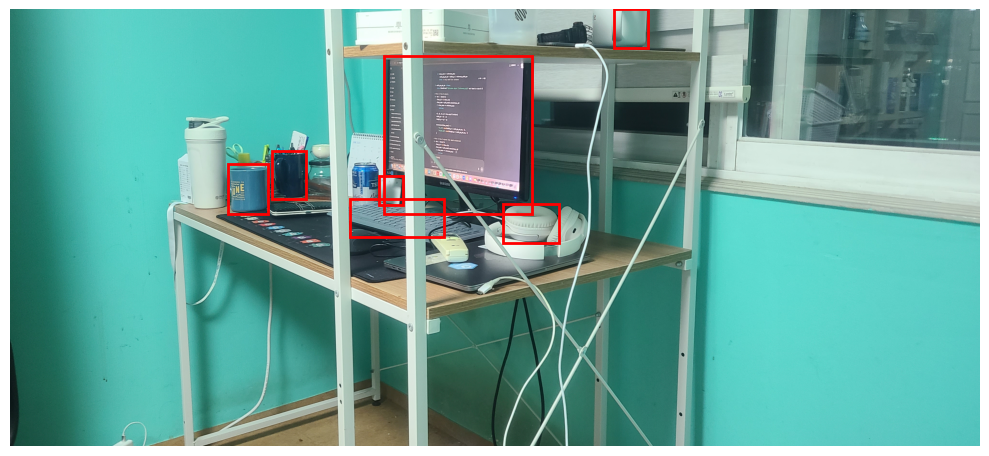

In [107]:
image = Image.open(input_path).convert("RGB")
visualize_segmented_images(image, results)

### 보너스: YOLO-WORLD를 이용한 분할

In [80]:
input_path = "test_images/chair2.jpg"

In [116]:
from ultralytics import YOLOWorld

# Initialize a YOLO-World model
model = YOLOWorld("yolov8s-world.pt")

In [117]:
# Define custom classes
# model.set_classes(["person", "bus"])

# Execute prediction on an image
results = model.predict(input_path)

# Show results
results[0].show()


image 1/1 /Users/brad/imagegenpoc/test_images/sample2.jpg: 288x640 1 skateboard, 1 cup, 1 chair, 1 bed, 1 tv, 1 book, 284.9ms
Speed: 4.2ms preprocess, 284.9ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 이미지 자르고 BLIP 프롬프트를 통한 레이블링

### 이미지 자르기

### BLIP 실행 

In [41]:
import torch
from transformers.pipelines import pipeline

In [126]:
cropping_pipeline = pipeline(
   task="visual-question-answering",
   model="Salesforce/blip-image-captioning-base",
   torch_dtype=torch.float32,
   device=1,
   use_safetensors=True
)

ValueError: Could not load model Salesforce/blip-image-captioning-base with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForVisualQuestionAnswering'>, <class 'transformers.models.blip.modeling_blip.BlipForConditionalGeneration'>). See the original errors:

while loading with AutoModelForVisualQuestionAnswering, an error is thrown:
Traceback (most recent call last):
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/pipelines/base.py", line 292, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py", line 600, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 4833, in from_pretrained
    ) = cls._load_pretrained_model(
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 5099, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 556, in load_state_dict
    check_torch_load_is_safe()
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/utils/import_utils.py", line 1517, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/pipelines/base.py", line 310, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py", line 600, in from_pretrained
    return model_class.from_pretrained(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 4833, in from_pretrained
    ) = cls._load_pretrained_model(
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 5099, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 556, in load_state_dict
    check_torch_load_is_safe()
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/utils/import_utils.py", line 1517, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

while loading with BlipForConditionalGeneration, an error is thrown:
Traceback (most recent call last):
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/pipelines/base.py", line 292, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 4833, in from_pretrained
    ) = cls._load_pretrained_model(
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 5099, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 556, in load_state_dict
    check_torch_load_is_safe()
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/utils/import_utils.py", line 1517, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/pipelines/base.py", line 310, in infer_framework_load_model
    model = model_class.from_pretrained(model, **fp32_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 311, in _wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 4833, in from_pretrained
    ) = cls._load_pretrained_model(
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 5099, in _load_pretrained_model
    load_state_dict(checkpoint_files[0], map_location="meta", weights_only=weights_only).keys()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py", line 556, in load_state_dict
    check_torch_load_is_safe()
  File "/Users/brad/imagegenpoc/.venv/lib/python3.12/site-packages/transformers/utils/import_utils.py", line 1517, in check_torch_load_is_safe
    raise ValueError(
ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434




In [105]:
for box in results[0].boxes:
	print(box.xyxy[0].cpu().numpy())

[       1555      195.15      2171.3      849.52]
[     905.42      642.21      1073.5      850.13]
[     1087.9      590.32        1231      787.55]
[     1535.4      691.52      1633.3      815.27]
[     1412.5      789.83      1804.2      947.18]
[     2050.5      809.91      2279.8      972.05]
[     2509.5    0.020698      2651.7      160.65]


/var/folders/rg/cmtcr_3n3g5bk2x49f7jdpdw0000gn/T/ipykernel_37987/525972424.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())


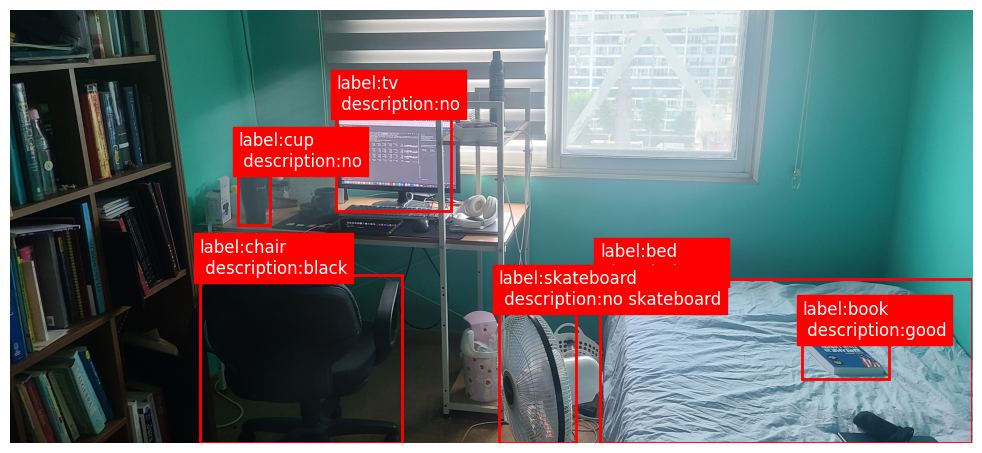

In [123]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = Image.open(input_path).convert("RGB")

# Create matplotlib figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

for box in results[0].boxes:
    # Get YOLO label
    class_id = int(box.cls.cpu().numpy())
    label_name = yolo_model.names[class_id]

    # Crop the image
    crop_box = box.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    cropped = image.crop(crop_box)

    # Get BLIP result
    result = cropping_pipeline(
        question=f"Describe the {label_name}'s color, texture, and style, only adjectives.",
        image=cropped,
        generate_kwargs={
            "num_beams": 3,
            "do_sample": False,
        }
    )
    description = result[0].get("answer", "unknown")

    # Draw box and label
    x1, y1, x2, y2 = crop_box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )

    # description = {
    #     "name": label_name,
    #     "description": label
    # }


    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"label:{label_name}\n description:{description}", fontsize=12, color="white", backgroundcolor="red")

plt.axis("off")
plt.tight_layout()
plt.show()
